This notebook contains all code to reproduce results in the paper "[A demographic and sentiment analysis of e-cigarette messages on Twitter](http://dml.cs.byu.edu/chs/Content-CHS-WS15/CHS-4.pdf)", by Elaine Cristina Resende and [Aron Culotta](http://cs.iit.edu/~culotta), published in the Computational Health Sciences Workshop at the 6th ACM Conference on Bioinformatics, Computational Biology, and Health Informatics, 2015. Please email Aron with any questions.

### Data

We begin with 4.6M tweets from 2012-10-01 to 2013-09-30 collected by [Sherry Emery](http://www.ihrp.uic.edu/researcher/sherry-l-emery-mba-phd)'s lab. These tweets have already been classified as "organic" or not using an SVM classifier (see Huang, Jidong et al. ["A cross-sectional examination of marketing of electronic cigarettes on Twitter." Tobacco control](http://tobaccocontrol.bmj.com/content/23/suppl_3/iii26.full)). We restrict our analysis to those classified as organic. We will assume these data live in `/data/chs15/ecig.csv.gz`.

In [1]:
from collections import Counter, defaultdict
import cPickle
import csv
import datetime
import gzip
import itertools
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import re
import requests
import scipy
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, precision_recall_fscore_support
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
import string
from tabulate import tabulate

%matplotlib inline

DATA = '/data/chs15'

In [2]:
def read_csv(filename, fields=['text', 'svm', 'hand_label', 'posted_time', 'real_name', 'username']):
    f = gzip.open(filename, 'rb')
    csvr = csv.DictReader(f, delimiter=',', quotechar='"')
    for row in csvr:
        yield dict([(k, row[k]) for k in fields if k in row])

In [3]:
# Read all "organic" tweets.
raw_tweets = [r for r in read_csv(DATA + '/ecig.csv.gz') if r['svm'] == '-']
print('read %d "organic" tweets' % len(raw_tweets))

read 992633 "organic" tweets


In [4]:
# Mark tweets with unique strings.
tweet_strings = set()
for t in raw_tweets:
    if t['text'] not in tweet_strings:
        t['unique'] = True
        tweet_strings.add(t['text'])
    else:
        t['unique'] = False
print('%d of %d tweets are unique' % (len([t for t in raw_tweets if t['unique']]), len(raw_tweets)))
tweet_strings = None

781799 of 992633 tweets are unique


Next, we manually labeled 2,000 tweets into one of three categories:
- **negative (0):** express negative sentiment toward ecigs *or* do not express sentiment, e.g., informative
- **neutral (1):** express no sentiment.
- **positive (2):** express positive sentiment toward ecigs, or indicate that the speaker uses ecigs.

We assume these data live in `/data/chs15/labeled.csv.gz`.

In [5]:
labeled_tweets = [r for r in read_csv(DATA + '/labeled.csv.gz', fields=['text', 'sent', 'real_name', 'username'])]

print('read %d labeled tweets' % len(labeled_tweets))
# Set labels.

label_map = {'-1': 'negative', '0': 'neutral', '1': 'positive'}
labels = ['negative', 'neutral', 'positive']
#label_map = {'-1': 'negative', '0': 'neutral', '1': 'positive'}
#labels = ['negative', 'neutral', 'positive']
for t in labeled_tweets:
    t['sent'] = label_map[t['sent']]
             
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y = label_encoder.transform([t['sent'] for t in labeled_tweets])             
print('Label distribution=%s' % Counter(t['sent'] for t in labeled_tweets).most_common(3))

read 2000 labeled tweets
Label distribution=[('neutral', 1014), ('positive', 707), ('negative', 279)]


### Classifier Training

Using `labeled_tweets`, we'll train a logistic regression classifier.

In [6]:
# Tweet tokenizer.
def tokenize(text):
    punc_re = '[' + re.escape(string.punctuation) + ']'
    text = text.lower()
    text = re.sub('#(\S+)', r'HASHTAG_\1', text)
    text = re.sub('@(\S+)', r'MENTION_\1', text)
    text = re.sub('http\S+', 'THIS_IS_A_URL', text)
    text = re.sub(r'(.)\1\1\1+', r'\1', text)
    text = re.sub(r'[0-9]', '9', text)
    toks = []
    for tok in text.split():
        tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
        tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
        for subtok in tok.split():
            if re.search('\w', subtok):
                toks.append(subtok)
    return toks

In [7]:
vectorizer = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 2), max_df=1., min_df=2,
                             use_idf=True, tokenizer=tokenize, binary=False, norm='l2')
X = vectorizer.fit_transform(t['text'] for t in labeled_tweets)
print('Vectorized %d tweets. Found %d terms.' % (X.shape[0], X.shape[1]))
features = np.array(vectorizer.get_feature_names())

Vectorized 2000 tweets. Found 4824 terms.


In [8]:
# Print some sample tweets.
print 'POSITIVE\n', '\n'.join([t['text'] for t, l in zip(labeled_tweets, y) if l == 2][:50])
print '\nNEGATIVE\n', '\n'.join([t['text'] for t, l in zip(labeled_tweets, y) if l == 0][:100])
print '\nNEUTRAL\n', '\n'.join([t['text'] for t, l in zip(labeled_tweets, y) if l == 1][:50])

POSITIVE
Vaping kush&gt;Smoking kush
@LindaMcAvanMEP anything that attracts people away from tobacco cigarettes is a good thing, inc. ecig flavours. #EUecigBAN
I bought a Ecig today
My new baby. Stop smoking, start vaping :) http://t.co/HjdE74lk
@Kelbyjohnson14 Try the new E-cigarette. . Worth a try anyway.
my mom tries to convince my dad to switch to e-cigs like daily
RT @jaymer: @RepJimLyons?�Stop #H3639 by @jeffrey_sanchez , Millions have quit smoking with the #Ecig. #H3639 promotes #cigarettes and #canc�??
I left my e cig in my room .. greeat ..
@NewYorkEDM do you know if e-cigarettes are allowed in? Or do i need to sneak it
No cigarettes &amp; my ecig is empty..the struggle is real.
RT @VapeBans: @SimonCowell Just 1 #RT for your fellow #Vapers is all it takes. Show your 6.6mil followers that u care about the #EUEcigBan!
I like when Micah walks all over the house while tweeting and looking for his ecig charger..????
Ouh hell yes! #ejuice #watermelon #irishcream #earlgrey #vape #vap

In [9]:
def confusion(truths, preds, labels):
    m = confusion_matrix(truths, preds)
    m = np.vstack((labels, m))
    m = np.hstack((np.matrix([''] + list(labels)).T, m))
    return tabulate(m.tolist(), headers='firstrow')

def top_coef(clf, vocab, n=10):
    if len(clf.classes_) == 2:
        coefs = [clf.coef_[0], -clf.coef_[0]]
    else:
        coefs = clf.coef_
    for li, label in enumerate(clf.classes_):
        print('\nCLASS %s' % label)
        coef = coefs[li]
        top_coef_ind = np.argsort(coef)[::-1][:n]
        top_coef_terms = vocab[top_coef_ind]
        top_coef = coef[top_coef_ind]
        print '\n'.join(['%s\t%.3f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)])

def do_cv(X, y, labels, nfolds=10):
    cv = KFold(len(y), nfolds, random_state=123456)
    preds = []
    truths = []
    for train, test in cv:
        clf = LogisticRegression(class_weight='auto')
        clf.fit(X[train], y[train])
        preds.extend(clf.predict(X[test]))
        truths.extend(y[test])
    print ('accuracy=%.3f' % (accuracy_score(truths, preds)))
    print classification_report(truths, preds, target_names=labels)
    print confusion(truths, preds, labels)
    clf = LogisticRegression(class_weight='auto')
    clf.fit(X, y)
    return clf, truths, preds

clf, truths, preds = do_cv(X, y, label_encoder.classes_, 10)
top_coef(clf, features, 5)

accuracy=0.746
             precision    recall  f1-score   support

   negative       0.60      0.55      0.57       279
    neutral       0.78      0.84      0.81      1014
   positive       0.75      0.68      0.72       707

avg / total       0.74      0.75      0.74      2000

            negative    neutral    positive
--------  ----------  ---------  ----------
negative         153         67          59
neutral           59        855         100
positive          44        180         483

CLASS 0
you	2.573
smoking	2.370
smoking an	2.251
he	2.119
fuck	2.020

CLASS 1
THIS_IS_A_URL	5.079
e-cigarettes	1.660
de	1.343
la	1.169
99	1.165

CLASS 2
my	5.244
i	4.426
vaping	1.941
HASHTAG_vaping	1.583
HASHTAG_ecig	1.442


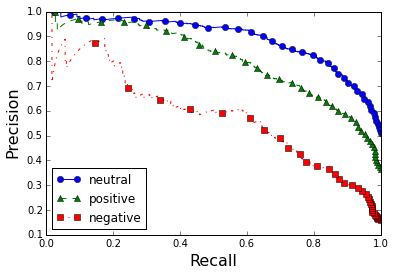

[ 0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6
  0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
label= negative
0.05 (0.59765625, 0.54838709677419351, 0.57196261682242988, None)
0.1 (0.59765625, 0.54838709677419351, 0.57196261682242988, None)
0.15 (0.59765625, 0.54838709677419351, 0.57196261682242988, None)
0.2 (0.59765625, 0.54838709677419351, 0.57196261682242988, None)
0.25 (0.59765625, 0.54838709677419351, 0.57196261682242988, None)
0.3 (0.59765625, 0.54838709677419351, 0.57196261682242988, None)
0.35 (0.60079051383399207, 0.54480286738351258, 0.57142857142857151, None)
0.4 (0.58878504672897192, 0.45161290322580644, 0.51115618661257611, None)
0.45 (0.63694267515923564, 0.35842293906810035, 0.4587155963302752, None)
0.5 (0.69230769230769229, 0.25806451612903225, 0.37597911227154046, None)
0.55 (0.84745762711864403, 0.17921146953405018, 0.29585798816568049, None)
0.6 (0.87179487179487181, 0.12186379928315412, 0.21383647798742136, None)
0.65 (0.800000000000000

/Users/awculott/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
def do_cv_thresh(X, y, labels, thresh=.5, nfolds=10):
    cv = KFold(len(y), nfolds, random_state=123456)
    preds = []
    truths = []
    probas = []
    for train, test in cv:
        clf = LogisticRegression(class_weight='auto')
        clf.fit(X[train], y[train])
        proba = clf.predict_proba(X[test])
        if len(probas) == 0:
            probas = proba
        else:
            probas = np.vstack((probas, proba))
        preds.extend(clf.predict(X[test]))
        truths.extend(y[test])
    # Plot precision/recall.
    plt.clf()
    for i, l, fmt in [(1, 'neutral', 'bo-'), (2, 'positive', 'g^--'), (0, 'negative', 'rs-.')]:
        precision, recall, _ = precision_recall_curve([1 if t==i else 0 for t in truths], probas[:, i])
        plt.plot(recall, precision, fmt, label=l, markevery=50)
    plt.legend(loc='lower left')
    plt.xlabel('Recall', size=16)
    plt.ylabel('Precision', size=16)
    plt.savefig('prec_rec.pdf', bbox_inches='tight')
    plt.show()
                       
    # Now deterime best threshold for each class to maximize F1.
    thresholds = np.arange(1,21) * .05
    print thresholds
    for i, l in enumerate(labels):
        print 'label=', l
        for thresh in thresholds:
            newpreds = [1 if l2==i and probas[j][i] >= thresh else 0 for j, l2 in enumerate(preds)]
            newtruths = [1 if t==i else 0 for t in truths]
            #print Counter(newpreds)
            print thresh, precision_recall_fscore_support(newtruths, newpreds, average='binary')
    print ('accuracy=%.3f' % (accuracy_score(truths, preds)))
    print classification_report(truths, preds, target_names=labels)
    print confusion(truths, preds, labels)
    clf = LogisticRegression(class_weight='auto')
    clf.fit(X, y)
    return clf, truths, preds

clf, truths, preds = do_cv_thresh(X, y, label_encoder.classes_, .1, 10)

In [11]:
# Write cross-validation results .tex table.
def clfreport_to_tex(report, outfile):
    """ Write a sklearn classification report as a latex table. """
    report = re.sub(r' \/ total', '', report)
    report = re.sub(r'precision', 'Prec', report)
    report = re.sub(r'recall', 'Rec', report)
    report = re.sub(r'f1-score', 'F1', report)
    report = re.sub(r'support', 'N', report)
    table = ['\\begin{tabular}{|r|c|c|c|c|}', '\\hline']
    lines = report.split('\n')
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) > 0:
            if i == 0:
                parts = [''] + ['{\\bf %s}' % p for p in parts]
            else:
                parts[0] = '{\\bf %s}' % parts[0]
            table.append(' & '.join(parts) + '\\\\')
        else:
            table.append('\\hline')
    table.append('\\end{tabular}')
    of = open(outfile, 'wt')
    of.write('\n'.join(table))
    
clfreport_to_tex(classification_report(truths, preds, target_names=labels), 'cv.tex')

In [12]:
# Write top coef .tex table.
def clean(s):
    s = re.sub('HASHTAG_', '\#', s)
    s = re.sub('MENTION_', '@', s)
    s = re.sub('THIS_IS_A_URL', 'URL', s)
    s = re.sub(r'_', '\\_', s)
    return s
    
def write_top_coef(clf, vocab, labels, outf, n=20):
    out = open(outf, 'wt')
    # coefs = [-clf.coef_[0], clf.coef_[0]]
    coefs = clf.coef_
    for li, label in enumerate(labels):
        coef = coefs[li]
        top_coef_ind = np.argsort(coef)[::-1][:n]
        top_coef_terms = vocab[top_coef_ind]
        out.write('{\\bf %s} & %s\\\\\n\hline\n' % (label, ', '.join(clean(s) for s in top_coef_terms)))
        
write_top_coef(clf, features, labels, 'coef.tex', n=20)


### Applying classifier

Next, we classify all the unlabeled tweets using the classifier.

In [13]:
X_raw = vectorizer.transform(t['text'] for t in raw_tweets)

In [14]:
#preds_raw = clf.predict(X_raw)
#print('predicted label distribution on raw tweets: %s' % Counter(preds_raw).most_common(3))
#for tweet, pred in zip(raw_tweets, preds_raw):
#    tweet['sent'] = labels[pred]

In [15]:
# Set thresholds so that recall=.25  # xx precision >= .8
neg_threshold = .5
pos_threshold = .65
# Relabel all unlabeled tweets.
probas_raw = clf.predict_proba(X_raw)
preds_raw = clf.predict(X_raw)

def get_thresh_label(proba, pred, neg_t, pos_t):
    if pred == 1:
        return 1
    elif pred == 0:
        if proba[0] >= neg_t:
            return pred
        else:
            return 1
    else:
        if proba[2] >= pos_t:
            return pred
        else:
            return 1
        
print('predicted label distribution on raw tweets: %s' % Counter(preds_raw).most_common(3))
preds_raw = np.array([get_thresh_label(proba, pred, neg_threshold, pos_threshold) for proba, pred in zip(probas_raw, preds_raw)])
print('adjusted predicted label distribution on raw tweets: %s' % Counter(preds_raw).most_common(3))
for tweet, pred in zip(raw_tweets, preds_raw):
    tweet['sent'] = labels[pred]

predicted label distribution on raw tweets: [(1, 537880), (2, 331359), (0, 123394)]
adjusted predicted label distribution on raw tweets: [(1, 832878), (2, 103103), (0, 56652)]


In [16]:
sent_counts = Counter(preds_raw)
print 'sentiment: pos / (pos + neg)=%.2f%%' % (100. * sent_counts[2] / (sent_counts[2] + sent_counts[0]))

sentiment: pos / (pos + neg)=64.54%


### Gender

Next, we classify each user by gender using a list of names from the census.

In [17]:
def get_gender_names(cutoff=75):
    males_url = 'http://www2.census.gov/topics/genealogy/1990surnames/dist.male.first'
    females_url = 'http://www2.census.gov/topics/genealogy/1990surnames/dist.female.first'
    males = set([l.split()[0].lower() for l in requests.get(males_url).text.split('\n') if l and float(l.split()[2]) < cutoff])
    females = set([l.split()[0].lower() for l in requests.get(females_url).text.split('\n') if l and float(l.split()[2]) < cutoff ])
    print('found %d male and %d female names with cutoff=%.2f' % (len(males), len(females), cutoff))
    return remove_ambiguous_names(males, females)

def remove_ambiguous_names(male_names, female_names):
    ambiguous = male_names & female_names
    male_names -= ambiguous
    female_names -= ambiguous
    print('removed %d ambiguous names, leaving %d males and %d females' % (len(ambiguous), len(male_names), len(female_names)))
    return male_names, female_names
    
male_names, female_names = get_gender_names()

found 232 male and 523 female names with cutoff=75.00
removed 6 ambiguous names, leaving 226 males and 517 females


In [18]:
def label_genders(tweets, male_names, female_names):
    for t in tweets:
        if len(t['real_name'])>1:
            first = t['real_name'].split()[0].lower()
        else:
            first = t['real_name'].lower()
        if first in male_names:
            t['gender'] = 'male'
        elif first in female_names:
            t['gender'] = 'female'
        else:
            t['gender'] = 'unknown'
label_genders(raw_tweets, male_names, female_names)
print('overall gender distribution=%s' % Counter(t['gender'] for t in raw_tweets).most_common(3))

overall gender distribution=[('unknown', 732856), ('male', 156902), ('female', 102875)]


In [19]:
print('most common male names: %s' % Counter(t['real_name'].split()[0] for t in raw_tweets if t['gender'] == 'male').most_common(10))
print('most common female names: %s' % Counter(t['real_name'].split()[0] for t in raw_tweets if t['gender'] == 'female').most_common(10))
print('most common unknown names: %s' % Counter(t['real_name'].split()[0] for t in raw_tweets if t['real_name'] and t['gender'] == 'unknown').most_common(10))

most common male names: [('Mark', 9017), ('Paul', 4531), ('John', 4393), ('Michael', 3748), ('Chris', 3662), ('Adam', 3539), ('Alex', 3215), ('Gregory', 2916), ('David', 2747), ('James', 2732)]
most common female names: [('Sarah', 2007), ('Ashley', 1399), ('Jessica', 1320), ('Emily', 1318), ('Rachel', 1212), ('Amanda', 1208), ('Katie', 1121), ('Laura', 1116), ('Mandy', 1087), ('Lauren', 1084)]
most common unknown names: [('Electronic', 15305), ('Dragonfly', 14279), ('The', 5898), ('Lewisville', 4837), ('g', 4588), ('Vapornine', 4105), ('Matt', 3573), ('?', 3237), ('DFW', 2904), ('Nick', 2466)]


### Age

To guess age from a user's name, we use the idea from from [Nate Silver's](https://twitter.com/FiveThirtyEight) recent article on [How to Tell Someone's Age When All you Know is Her Name](http://fivethirtyeight.com/features/how-to-tell-someones-age-when-all-you-know-is-her-name/). We borrow from [this notebook](https://github.com/ramnathv/agebyname_py) by [@ramnathv](https://github.com/ramnathv).

First, we download a list of [baby names](http://www.ssa.gov/oact/babynames/names.zip) provided by the SSA.

In [20]:
import urllib
names_file = DATA + '/names.zip'
urllib.urlretrieve('http://www.ssa.gov/oact/babynames/names.zip', DATA + '/names.zip')

('/data/chs15/names.zip', <httplib.HTTPMessage instance at 0x1202e3098>)

In [21]:
# Read list of names.
import pandas as pd
from zipfile import ZipFile

def read_names(f, zf):
  data = pd.read_csv(zf.open(f), header = None, names = ['name', 'sex', 'n'])
  data['year'] = int(re.findall(r'\d+', f)[0])
  return data
  
names_zip = ZipFile(names_file)
bnames = pd.concat([read_names(f, names_zip) for f in names_zip.namelist() if f.endswith('.txt')])
names_ =  set(bnames.name)
bnames.head()

,name,sex,n,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


Next we parse the [cohort life tables](http://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7.html) provided by SSA, using @ramnathv's export.

In [22]:
from scipy.interpolate import interp1d

lifetables = pd.read_csv(DATA + '/lifetables.csv')
lifetables_2014 = lifetables[lifetables['year'] + lifetables['x'] == 2014]
lifetables_2014.head()

# interpolate gaps
def process(d, kind = 'slinear'):
  f = interp1d(d.year, d.lx, kind)
  year = np.arange(1900, 2011)
  lx = f(year)
  return pd.DataFrame({"year": year, "lx": lx, "sex": d.sex.iloc[1]})

lifetable_2014 = lifetables_2014.\
  groupby('sex', as_index = False).\
  apply(process)
lifetable_2014.head()

lx sex  year
0 0   0.0   F  1900
  1  19.1   F  1901
  2  38.2   F  1902
  3  57.3   F  1903
  4  76.4   F  1904

Finally, we use the [live births data](http://www.census.gov/statab/hist/02HS0013.xls) from the census to extrapolate the birth data to account for the correct that not all births were recorded by SSA till around 1930, since it wasn't mandatory.

In [23]:
# Download the data and add a correction factor.
urllib.urlretrieve("http://www.census.gov/statab/hist/02HS0013.xls", DATA + "/02HS0013.xls")
dat = pd.read_excel(DATA + '/02HS0013.xls', sheetname = 'HS-13', skiprows = range(14))
tot_births = dat.ix[9:101,:2].reset_index(drop = True)
tot_births.columns = ['year', 'births']
tot_births = tot_births.convert_objects(convert_numeric = True)
print tot_births.head()
# Correction factors.
cor_factors = bnames.groupby('year', as_index = False).sum().merge(tot_births)
cor_factors['cor'] = cor_factors['births']*1000/cor_factors['n']
cor_factors = cor_factors[['year', 'cor']]
cor_new = pd.DataFrame({
  'year': range(2002, 2014),
  'cor': cor_factors.cor.iloc[-1]
})
cor_factors = pd.concat([cor_factors, cor_new])[['year', 'cor']]
print cor_factors.head()

   year  births
0  1909    2718
1  1910    2777
2  1911    2809
3  1912    2840
4  1913    2869
   year       cor
0  1909  5.316621
1  1910  4.701051
2  1911  4.359994
3  1912  2.874354
4  1913  2.523141


In [24]:
# For efficiency, define name as index of the table
bname= bnames.set_index(['name'], inplace=True)

In [25]:
# This function tells the number of births and number of people alive. 
def get_data(name):
    dat = bnames
    dat = dat.loc[name]
    if type(dat) == pd.Series:
        m = pd.DataFrame(bnames.loc[name]).transpose()
    else:
        m = dat
    data =   m.\
            merge(cor_factors).\
            merge(lifetable_2014)
    data['n_cor'] = data['n']*data['cor']
    data['n_alive'] = data['lx']/(10**5)*data['n_cor']
    return data

print('Joseph')
print get_data('Edward').tail()
print('Irene')
print get_data('Irene').tail()

Joseph
    sex     n  year       cor       lx        n_cor      n_alive
193   F     7  2007  1.076384  99351.7     7.534690     7.485842
194   M  2820  2007  1.076384  99221.6  3035.403577  3011.775996
195   M  2783  2008  1.076384  99256.4  2995.577360  2973.302247
196   M  2979  2009  1.076384  99291.2  3206.548673  3183.820656
197   M  2898  2010  1.076384  99326.0  3119.361549  3098.337052
Irene
    sex    n  year       cor       lx       n_cor     n_alive
169   F  492  2006  1.076384  99324.6  529.581050  526.004259
170   F  467  2007  1.076384  99351.7  502.671443  499.412624
171   F  482  2008  1.076384  99378.8  518.817207  515.594315
172   F  479  2009  1.076384  99405.9  515.588054  512.524946
173   F  408  2010  1.076384  99433.0  439.164773  436.674709


In [26]:
# Now we can map each name to a distribution over age brackets.
def first_name(name):
    if len(name) > 1:
        name = name.split()[0].lower().title()
    else:
        name = name.lower().title()
    return name


def age_brackets(name):    
    name = first_name(name)
    dic = defaultdict(list)
    #
    s=0 
    s1=0
    s2=0
    s3=0
    s4=0
    s5=0
    #fraction of percentages
    f=0  
    f1=0
    f2=0
    f3=0
    f4=0    
    f5=0
    
    m = get_data(name).as_matrix()
    if len(m) != 0:
        for t in m:
            if t[2]>=1996: # 0-18
                s = s+t[1]
                f = f + t[6]
                dic['<18'] = f
            elif t[2] >= 1990 and t[3]<=1995: #19-24
                s1 = s1+t[1]
                f1 = f1 + t[6]
                dic['18-24'] = f1
            elif t[2] >= 1980 and t[3]<=1989: #25-34
                s2 = s2+t[1]
                f2 = f2 + t[6]
                dic['25-34'] = f2
            elif t[2] >= 1970 and t[3]<=1979: #35-44
                s3 = s3+t[1]
                f3 = f3 + t[6]
                dic['35-44'] = f3
            elif t[2] <= 1960 :#and t[2] <= 1969: #45-54
                s4 = s4+t[1]
                f4 = f4 + t[6]
                dic['>=45'] = f4
        total = sum(dic.values())
        return dict([(k, 1.*v/total*100) for k, v in dic.iteritems()])
    
print('Irene')
print age_brackets('Irene')
print('Michael')
print age_brackets('Michael')
print('Payton')
print age_brackets('Payton')

Irene
{'35-44': 5.9900770087280355, '>=45': 79.96979901362864, '18-24': 2.768896935891503, '25-34': 5.300358368654281, '<18': 5.970868673097543}
Michael
{'35-44': 21.724002632069023, '>=45': 33.05996262251043, '18-24': 10.25125353909169, '25-34': 21.20556963381044, '<18': 13.759211572518417}
Payton
{'35-44': 0.4265604073936273, '>=45': 0.5359894837394966, '18-24': 6.8700057813423445, '25-34': 1.2200035112432313, '<18': 90.9474408162813}


In [27]:
def label_ages(tweets, valid_names):
    name_cache = {}
    for ti, t in enumerate(tweets):
        name = first_name(t['real_name'])
        if name in valid_names:
            if name in name_cache:
                distr = name_cache[name]
            else:
                distr = age_brackets(name)
                name_cache[name] = distr
            t['ages'] = distr
        
        if ti % 10000 == 0:
            print('processed %d tweets' % ti)
        ti += 1
        
label_ages(raw_tweets, names_)

processed 0 tweets
processed 10000 tweets
processed 20000 tweets
processed 30000 tweets
processed 40000 tweets
processed 50000 tweets
processed 60000 tweets
processed 70000 tweets
processed 80000 tweets
processed 90000 tweets
processed 100000 tweets
processed 110000 tweets
processed 120000 tweets
processed 130000 tweets
processed 140000 tweets
processed 150000 tweets
processed 160000 tweets
processed 170000 tweets
processed 180000 tweets
processed 190000 tweets
processed 200000 tweets
processed 210000 tweets
processed 220000 tweets
processed 230000 tweets
processed 240000 tweets
processed 250000 tweets
processed 260000 tweets
processed 270000 tweets
processed 280000 tweets
processed 290000 tweets
processed 300000 tweets
processed 310000 tweets
processed 320000 tweets
processed 330000 tweets
processed 340000 tweets
processed 350000 tweets
processed 360000 tweets
processed 370000 tweets
processed 380000 tweets
processed 390000 tweets
processed 400000 tweets
processed 410000 tweets
proces

In [28]:
def add_to_dict(d, d1):
    for k in d1:
        d[k] += d1[k]
    
all_ages = defaultdict(lambda: 0)
for t in raw_tweets:
    if 'ages' in t and t['ages']:
        add_to_dict(all_ages, t['ages'])
        
print 'overall ages:'
for k, v in all_ages.iteritems():
    print('%s\t%.2f' % (k, v / sum(all_ages.values())))

overall ages:
25-34	0.16
>=45	0.27
18-24	0.12
35-44	0.14
<18	0.30


In [29]:
# Assign each tweet its most probable age.
age_counts = defaultdict(lambda: 0)
for t in raw_tweets:
    if 'ages' in t and t['ages'] is not None and len(t['ages']) > 0:
        items = t['ages'].items()
        pred_age = items[np.argmax([it[1] for it in items])][0]
        t['pred_age'] = pred_age
        age_counts[pred_age] += 1
    
for a in ['<18', '18-24', '25-34', '35-44', '>=45']:
    print a, age_counts[a]

<18 210325
18-24 13613
25-34 61475
35-44 46411
>=45 204490


In [30]:
# Save our annotated tweets.
cPickle.dump(raw_tweets, open(DATA + '/raw_tweets.pkl', 'wb'))

### Figures

Next we create a number of figures to explore how ecig sentiment varies by time, gender, and age.

In [31]:
def format_month(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0' + parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

def group_by_month(tweets):
    by_month = defaultdict(lambda: [])
    for t in tweets:
        t['month'] = format_month(t['posted_time'])
        by_month[t['month']].append(t)
    return by_month
    
by_month = group_by_month(raw_tweets)

In [32]:
print '\n'.join(['%s\t%d' % (m, len(by_month[m])) for m in sorted(by_month)])

2012-10-01	30026
2012-11-01	36995
2012-12-01	46271
2013-01-01	62883
2013-02-01	65971
2013-03-01	90870
2013-04-01	110735
2013-05-01	84692
2013-06-01	96447
2013-07-01	94180
2013-08-01	114894
2013-09-01	158669


In [33]:
def check_keyvals(t, keyvals):
    for keyval in keyvals:
        if keyval[0] not in t or t[keyval[0]] != keyval[1]:
            return False
    return True

def filter_tweets(tweets, ignore_rt=True, uniq_users=True, uniq_tweets=True, keyvals=None):
    return np.array(tweets)[filter_tweets_ind(tweets, ignore_rt, uniq_users, uniq_tweets, keyvals)]

def filter_tweets_ind(tweets, ignore_rt=True, uniq_users=True, uniq_tweets=True, keyvals=None):
    users = set()
    indices = []
    for i, t in enumerate(tweets):
        if ignore_rt and t['text'][:2] == 'RT':
            continue
        elif uniq_tweets and not t['unique']:
            continue
        elif uniq_users and t['username'] in users:
            continue
        else:
            if keyvals and not check_keyvals(t, keyvals):
                continue
            users.add(t['username'])
            indices.append(i)
    return indices

In [34]:
def count_tweets(by_month, ignore_rt=True, uniq_users=True, uniq_tweets=True, keyvals=None):
    vals = []
    for month in sorted(by_month):
        vals.append(len(filter_tweets(by_month[month], ignore_rt, uniq_users, uniq_tweets, keyvals)))
    return np.array(vals)

In [35]:
def get_lines():
    markers = ['o', '^', 's', '*', 'D', '^', 's', '*', 'D', 'o']
    lines = ['-', '--', '-.', ':'] * 3
    return itertools.cycle(['%s%s' % (m, l) for l, m in zip(lines, markers)])

male 63.4885764499
female 61.6357003478
<18 62.0958394948
18-24 66.5975103734
25-34 62.0661270407
35-44 64.4798500469
>=45 63.8186064617


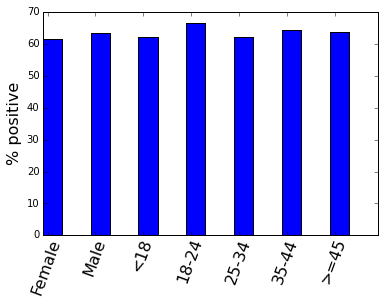

In [36]:
def plot_frac_pos(raw_tweets):
    male_pos = len(filter_tweets(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'male']]))
    male_neg = len(filter_tweets(raw_tweets, keyvals=[['sent', 'negative'], ['gender', 'male']]))
    male_pos_frac = 100. * male_pos / (male_pos + male_neg)

    
    female_pos = len(filter_tweets(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'female']]))
    female_neg = len(filter_tweets(raw_tweets, keyvals=[['sent', 'negative'], ['gender', 'female']]))
    female_pos_frac = 100. * female_pos / (female_pos + female_neg)
    print 'male', male_pos_frac
    print 'female', female_pos_frac
    vals = [female_pos_frac, male_pos_frac]
    ages = ['<18', '18-24', '25-34', '35-44', '>=45']
    for a in ages:
        frac_pos = len(filter_tweets(raw_tweets, keyvals=[['sent', 'positive'], ['pred_age', a]]))
        frac_neg = len(filter_tweets(raw_tweets, keyvals=[['sent', 'negative'], ['pred_age', a]]))
        frac = 100. * frac_pos / (frac_pos + frac_neg)
        print a, frac
        vals.append(frac)
        
    plt.figure()
    xvals = np.arange(len(ages) + 2)
    plt.bar(xvals, vals, .4)
    plt.xticks(xvals + .1, ['Female', 'Male'] + ages, size=16)
    plt.ylabel('% positive', size=16)
    plt.xticks(rotation=70) 
    plt.savefig('pct_pos.pdf', bbox_inches='tight')
    plt.show()
        
    
plot_frac_pos(raw_tweets)

total tweets after all filtering: 455648
tweets per month after filtering: [(datetime.date(2012, 10, 1), 16172), (datetime.date(2012, 11, 1), 18421), (datetime.date(2012, 12, 1), 20960), (datetime.date(2013, 1, 1), 31159), (datetime.date(2013, 2, 1), 31685), (datetime.date(2013, 3, 1), 41070), (datetime.date(2013, 4, 1), 37283), (datetime.date(2013, 5, 1), 39293), (datetime.date(2013, 6, 1), 47524), (datetime.date(2013, 7, 1), 45658), (datetime.date(2013, 8, 1), 55373), (datetime.date(2013, 9, 1), 71050)]


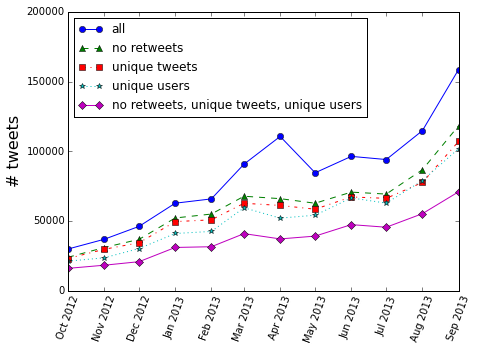

In [37]:
def plot_raw_counts(by_month):
    linecycler = get_lines()
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    ax.plot(months, count_tweets(by_month, ignore_rt=False, uniq_users=False, uniq_tweets=False), next(linecycler), label='all')
    ax.plot(months, count_tweets(by_month, ignore_rt=True, uniq_users=False, uniq_tweets=False), next(linecycler), label='no retweets')
    ax.plot(months, count_tweets(by_month, ignore_rt=True, uniq_users=False, uniq_tweets=True), next(linecycler), label='unique tweets')
    ax.plot(months, count_tweets(by_month, ignore_rt=False, uniq_users=True, uniq_tweets=False), next(linecycler), label='unique users')
    ax.plot(months, count_tweets(by_month, ignore_rt=True, uniq_users=True, uniq_tweets=True), next(linecycler), label='no retweets, unique tweets, unique users')
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.ylim((0, 200000))
    plt.legend(loc='upper left')
    plt.ylabel('# tweets', size=16)
    plt.savefig('raw_counts.pdf', bbox_inches='tight')
    print 'total tweets after all filtering:', sum(count_tweets(by_month, ignore_rt=True, uniq_users=True, uniq_tweets=True))
    print 'tweets per month after filtering:', zip(months, count_tweets(by_month, ignore_rt=True, uniq_users=True, uniq_tweets=True))
    plt.show()
    
plot_raw_counts(by_month)

percent positive by month: [ 65.84835301  66.10682819  68.61435726  66.13458529  66.25246249
  61.11111111  66.072295    68.43559342  71.63416899  74.223473
  71.60621762  64.98935415]
coef= [ 0.41369868]


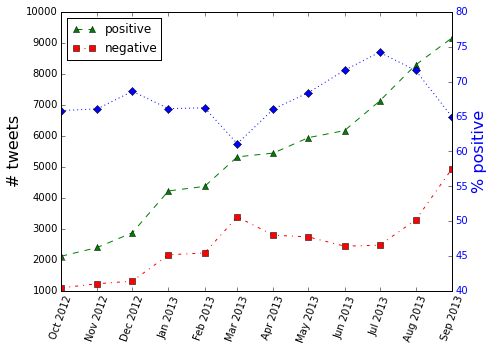

In [38]:
def plot_sentiment(by_month):
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    all_counts = count_tweets(by_month)
    pos_counts = count_tweets(by_month, keyvals=[['sent', 'positive']])
    neg_counts = count_tweets(by_month, keyvals=[['sent', 'negative']])
    # neut_counts = count_tweets(by_month, keyvals=[['sent', 'neutral']])
    pos_fraction = 100. * pos_counts / (pos_counts + neg_counts)
    #pos_fraction = 100. * np.array(pos_counts) / np.array(all_counts)
    # ax.plot(months, all_counts , 'ko-', label='all')
    #ax.plot(months, neut_counts , 'ko-', label='neutral')
    ax.plot(months, pos_counts, 'g^--', label='positive')
    ax.plot(months, neg_counts, 'rs-.', label='negative')

    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')

    ax2 = ax.twinx()
    ax2.plot(months, pos_fraction, 'bD:')
    print 'percent positive by month:', pos_fraction
    m = LinearRegression()
    m.fit([[x] for x in range(1, len(pos_fraction) + 1)], pos_fraction)
    print 'coef=', m.coef_
    ax2.set_ylabel('% positive', color='b', size=16)
    ax2.set_ylim((40, 80))
    for tl in ax2.get_yticklabels():
        tl.set_color('b')

    ax.set_ylabel('# tweets', size=16)
    plt.savefig('sentiment.pdf', bbox_inches='tight')
    plt.show()    
    
plot_sentiment(by_month)

In [43]:
import random

def search_tweets(tweets, text, keyvals, n=100):
    # Sample tweets matching search term and keyvals filter.
    random.seed(1234567)
    matches = [t for t in filter_tweets(tweets) if check_keyvals(t, keyvals) and text in t['text'].lower()]
    return random.sample(matches, min(n, len(matches)))

def join_terms(terms):
    return ', '.join(clean(s) for s in terms)

def feat_counts(fi,ci,X,y):
    return sum([1 for (xs,yi) in zip(X,y) if yi == ci and xs[fi] > 0])

def get_pos_mask(X, y, feats, reg=1):
    """ Get mask for indices that are more associated with class 1 than class 0. """
    posp = ((1 + X[np.where(y == 1)].sum(axis=0)) / X[np.where(y == 1)].sum()).getA1()
    negp = ((1 + X[np.where(y == 0)].sum(axis=0)) / X[np.where(y == 0)].sum()).getA1()
    diffs = posp - negp
    diffs = np.array([1 if v > 0 else 0 for v in diffs])
    return np.array(diffs)
    
    
def top_terms(X_real, target_ind, base_ind, feats, n=20):
    base_ind = np.array(list(set(base_ind) - set(target_ind)))
    print '%d target and %d base indices' % (len(target_ind), len(base_ind))
    X = X_real.sign()
    subX = X[np.concatenate((target_ind, base_ind))]
    y = np.array([1] * len(target_ind) + [0] * len(base_ind))
    probs = get_pos_mask(subX, y, feats)
    chi, _ = chi2(subX, y)
    chi = np.nan_to_num(chi * probs)
    found = 0
    result = []
    counts = X[target_ind].sum(axis=0).getA1()
    for idx in np.argsort(chi)[::-1]:
        feat = feats[idx]
        if ' ' not in feat and counts[idx] > 1:  # ignore terms that don't appear in at least 2 pos tweets.
            result.append(feat)
            found += 1
        if found == n:
            break
    return result

In [44]:
# Why the drop in March?
print '%d onew tweets in March' % len(search_tweets(raw_tweets, 'onew', [['month',  sorted(by_month)[5]]], n=1e10))
print '%d positive onew tweets in March' % len(search_tweets(raw_tweets, 'onew', [['sent', 'positive'], ['month',  sorted(by_month)[5]]], n=1e10))
print '%d negative onew tweets in March' % len(search_tweets(raw_tweets, 'onew', [['sent', 'negative'], ['month',  sorted(by_month)[5]]], n=1e10))
print '\n'.join(t['text'] for t in search_tweets(raw_tweets, 'onew', [['sent', 'negative'], ['month', sorted(by_month)[5]]]))
print 'terms in march'
print join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['month', sorted(by_month)[5]]]),
                range(X_raw.shape[0]), features))
print 'positive terms in march'
print join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive'], ['month', sorted(by_month)[5]]]),
                range(X_raw.shape[0]), features))
print 'negative terms in march'
print join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'negative'], ['month', sorted(by_month)[5]]]),
                range(X_raw.shape[0]), features))


1127 onew tweets in March
2 positive onew tweets in March
470 negative onew tweets in March
Lol is everyone still on about Onew smoking an electronic cigarette and about his Girlfriend? Seriously he's human.
Onew caught smoking an electronic cigarette?: Onew, who was recently swept up in a scandal with Jungah, is... http://t.co/wB4COi4xZx #fb
The way he smoke it is really cute RT @allkpop: Onew caught smoking an electronic cigarette? http://t.co/2pI7sdCMOd
Onew caught smoking an electronic cigarette?: Onew, who was recently swept up in a scandal with Jungah, is cau... http://t.co/EYHvSL36JH
Rumour about Onew : Middle finger incident,  Smoking an electronic cigarette, Dating Jungah After School.
WTF RT �??@allkpop: Onew caught smoking an electronic cigarette? http://t.co/cNxXnYeFoJ�??
@baeknhaneey @8meigeuns ak bru ngeh. Smoking~ onew smoking pke e-cigarette *syok*
Cc: @diyahrdewi RT @allkpop: Onew caught smoking an electronic cigarette? http://t.co/U4U8gsytCe
so RT @allkpop: Onew caugh

found 73647 male and 53528 female tweets


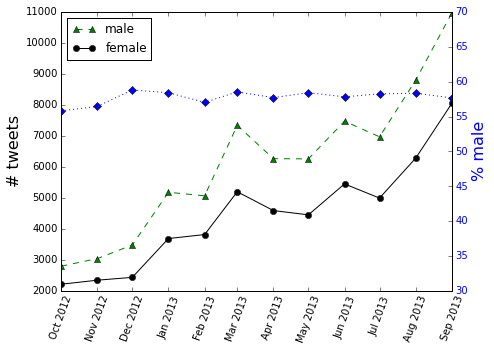

In [46]:
def plot_genders(by_month):
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    female_counts = count_tweets(by_month, keyvals=[['gender', 'female']])
    male_counts = count_tweets(by_month, keyvals=[['gender', 'male']])
    ax.plot(months, male_counts, 'g^--', label='male')
    ax.plot(months, female_counts , 'ko-', label='female')
    male_fraction = 100. * np.array(male_counts) / (np.array(male_counts) + np.array(female_counts))
    print 'found %d male and %d female tweets' % (sum(male_counts), sum(female_counts))
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')
    ax.set_ylabel('# tweets', size=16)
    
    ax2 = ax.twinx()
    ax2.plot(months, male_fraction, 'bD:')
    ax2.set_ylabel('% male', color='b', size=16)
    ax2.set_ylim((30, 70))
    for tl in ax2.get_yticklabels():
        tl.set_color('b')

    ax.set_ylabel('# tweets', size=16)

    plt.savefig('gender.pdf', bbox_inches='tight')
    plt.show()    
    
plot_genders(by_month)

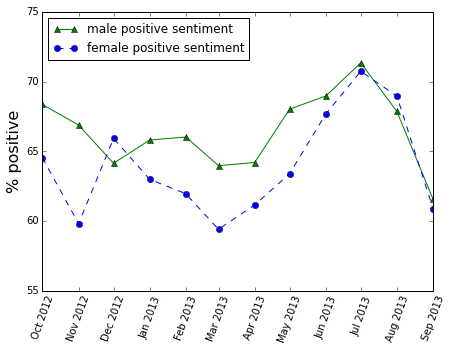

In [47]:
def plot_gender_sentiment(by_month):
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    male_pos = count_tweets(by_month, keyvals=[['gender', 'male'], ['sent', 'positive']])
    male_neg = count_tweets(by_month, keyvals=[['gender', 'male'], ['sent', 'negative']])
    malev = 100. *  male_pos / (male_pos + male_neg)
    
    
    female_pos = count_tweets(by_month, keyvals=[['gender', 'female'], ['sent', 'positive']])
    female_neg = count_tweets(by_month, keyvals=[['gender', 'female'], ['sent', 'negative']])
    # femalev = 100. * female_pos / female - 100. * female_neg / female
    femalev = 100. * female_pos / (female_pos + female_neg)
    
    ax.plot(months, malev, 'g^-', label='male positive sentiment')
    ax.plot(months, femalev, 'bo--', label='female positive sentiment')
    #ax.plot(months, 100. * np.array(female_pos) / (np.array(female)) , 'bo--', label='female positive sentiment')
    #ax.plot(months, 100. * np.array(male_pos) / (np.array(male)) , 'g^-', label='male positive sentiment')
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    ax.set_ylim((55, 75))
    plt.legend(loc='upper left')
    ax.set_ylabel('% positive', size=16)
    plt.savefig('gender_sentiment.pdf', bbox_inches='tight')
    plt.show()    
    
plot_gender_sentiment(by_month)

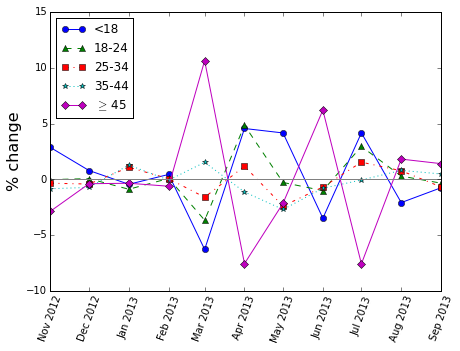

In [48]:
def count_ages(by_month, ignore_rt=True, uniq_users=True, uniq_tweets=True, keyvals=None):
    ages = []
    for month in sorted(by_month):
        sums = defaultdict(lambda: 0)
        matches = 0
        for t in filter_tweets(by_month[month], ignore_rt, uniq_users, uniq_tweets, keyvals):
            if 'ages' in t and t['ages'] is not None:
                add_to_dict(sums, t['ages'])
                matches += 1
        total = sum(sums.values())
        for k in sums:
            sums[k] /= total
        #for k in sums:
        #    sums[k] /= matches
        ages.append(sums)
    return ages

def pct_change(vals):
    return [100. * (v2-v1) / v1 for v1, v2 in zip(vals, vals[1:])]

def clean_age(a):
    if '45' in a:
        return '$\geq$ 45'
    else:
        return a

def plot_ages(by_month):
    lines = get_lines()
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    ages = count_ages(by_month)
    for a in ['<18', '18-24', '25-34', '35-44', '>=45']: # sorted(ages[0].keys()):
        #ax.plot(months, [x[a] for x in ages], next(lines), label=a)
        ax.plot(months[1:], pct_change([x[a] for x in ages]), next(lines), label=clean_age(a))
        #ax.plot(months[1:], count_ages([x[a] for x in ages]), next(lines), label=clean_age(a))
    ax.xaxis_date()
    plt.axhline(color='gray')
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')
    ax.set_ylabel('% change', size=16)
    
    plt.savefig('ages.pdf', bbox_inches='tight')
    plt.show()    
    
plot_ages(by_month)

In [49]:
all_ages = count_ages(by_month)
sums = defaultdict(lambda: 0)
for a in all_ages:
    add_to_dict(sums, a)
total = sum(sums.values())
for k in sums:
    sums[k] /= total
print sums


defaultdict(<function <lambda> at 0x124c4d320>, {'35-44': 0.13449193023053799, '>=45': 0.24842755529236391, '18-24': 0.12975683165881882, '25-34': 0.16279551354485308, '<18': 0.3245281692734262})


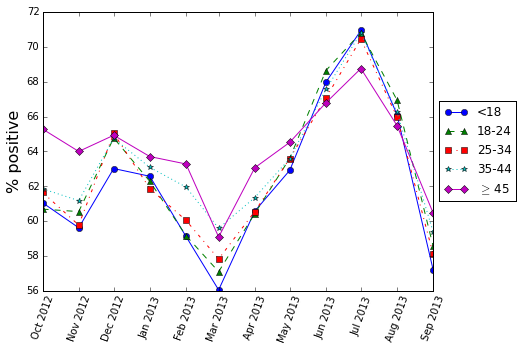

In [50]:
def count_age_sentiment(by_month, ignore_rt=True, uniq_users=True, uniq_tweets=True, keyvals=None):
    ages = []
    for month in sorted(by_month):
        sums_pos = defaultdict(lambda: 0)
        sums_neg = defaultdict(lambda: 0)
        for t in filter_tweets(by_month[month], ignore_rt, uniq_users, uniq_tweets, keyvals):
            if 'ages' in t and t['ages'] is not None:
                if t['sent'] == 'positive':
                    add_to_dict(sums_pos, t['ages'])
                elif t['sent'] == 'negative':
                    add_to_dict(sums_neg, t['ages'])
                
        pct_pos = dict()
        for k in sums_pos:
            pct_pos[k] = 100. * sums_pos[k] / (sums_neg[k] + sums_pos[k])
        ages.append(pct_pos)
    return ages

def plot_age_sentiment(by_month):
    lines = get_lines()
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    ages = count_age_sentiment(by_month)    
    for a in ['<18', '18-24', '25-34', '35-44', '>=45']: # sorted(ages[0].keys()):
        ax.plot(months, [x[a] for x in ages], next(lines), label=clean_age(a))
        #ax.plot(months[1:], pct_change([x[a] for x in ages]), next(lines), label=a)
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('% positive', size=16)
    # ax.set_ylim((52, 75))
    
    plt.savefig('age_sentiment.pdf', bbox_inches='tight')
    plt.show()    
    
plot_age_sentiment(by_month)

### Print top coefficients for each demographic/sentiment

In [52]:
def print_term_table(X_raw, raw_tweets, by_month, outf):        
    out = open(outf, 'wt')
    out.write('{\\bf Positive sentiment} & %s\\\\\n' % 
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive']]),
                range(len(raw_tweets)), features)))
                # filter_tweets_ind(raw_tweets, keyvals=[['sent', 'negative']]), features)))
    out.write('{\\bf Negative sentiment} & %s\\\\\n' %
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'negative']]),
                range(len(raw_tweets)), features)))
                # filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive']]), features)))
    out.write('\\hline\n')
    out.write('{\\bf Female} & %s\\\\\n' % 
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['gender', 'female']]),
                filter_tweets_ind(raw_tweets, keyvals=[['gender', 'male']]), features)))
    out.write('{\\bf Male} & %s\\\\\n' % 
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['gender', 'male']]),
                filter_tweets_ind(raw_tweets, keyvals=[['gender', 'female']]), features)))
    out.write('\\hline\n')
    for age in ['<18', '18-24', '25-34', '35-44', '>=45']:
        out.write('{\\bf %s} & %s\\\\\n' % (clean_age(age),
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['pred_age', age]]),
                                            [i for i, t in enumerate(raw_tweets) if 'pred_age' in t], features))))
    out.write('\\hline\n')
    for month in sorted(by_month):
        out.write('{\\bf %s} & %s\\\\\n' % (str(month)[:7],
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['month', month]]),
                                            range(len(raw_tweets)), features))))        
    out.close()
    
print_term_table(X_raw, raw_tweets, by_month, 'coef_demo.tex')


53920 target and 938713 base indices
29387 target and 963246 base indices
46852 target and 62397 base indices
62397 target and 46852 base indices
99186 target and 437128 base indices
6114 target and 530200 base indices
28351 target and 507963 base indices
18525 target and 517789 base indices
77692 target and 458622 base indices
16172 target and 976461 base indices
18421 target and 974212 base indices
20960 target and 971673 base indices
31159 target and 961474 base indices
31685 target and 960948 base indices
41070 target and 951563 base indices
37283 target and 955350 base indices
39293 target and 953340 base indices
47524 target and 945109 base indices
45658 target and 946975 base indices
55373 target and 937260 base indices
71050 target and 921583 base indices


** Examine trends in term usage. **

In [53]:
# Why are females positive in December?
print join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'female'], ['month', sorted(by_month)[2]]]),
                filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'female']]), features))
 

#print '\n'.join(t['text'] for t in search_tweets(raw_tweets, '', [['sent', 'positive'], ['gender', 'female'], ['month', sorted(by_month)[2]]]))
print '\n'.join(t['text'] for t in search_tweets(raw_tweets, 'christmas', [['gender', 'female'], ['month', sorted(by_month)[2]]]))

360 target and 6940 base indices
christmas, gift, parents, present, electric, @youtube, cigarette, sis, @v9cigs, r, win, future, game, e-juice, gay, store, ass, never, early, agree
Christmas is just around the corner, enter to win a SMOKO ecig Premium Starter Packs worth �45 http://t.co/nV2JBr53 http://t.co/JqZ3D1Rb
Buy me an e cig for christmas and I'll love you forever.
Babes quit smoking na. Haha!! RT �@RaINyourFACE: Alright, for my christmas wishlist, E-cig and Earphones�
my mom bought my dad an electronic cigarette for christmas �???
Got an electronic cigarette for Christmas, hopefully It'll help me quit!
My mom's charging electronic cigarettes go with the Christmas decorations. http://t.co/NlkrMJTH
I bought a VIP E-Cig last night. I don't need it, but it's just in case I do drink over Christmas and get tempted to smoke.
im gettin me a tredmill and an ecig tomorrow. my little christmas gift to myself ;)
#AllIWantForChristmasIs ELECTRONIC CIGARETTE :) LOL.
@kjmeow Hah! I'm giving p

In [54]:
print '\n'.join(t['text'] for t in search_tweets(raw_tweets, 'dad', [['gender', 'female']]))

My dad and my 17 year old brother are vaping together in my car lol. This is weird.
My dad, who has been smoking since he was 16, got an e-cigarette and hasn't had a cigarette in a week!
My dad is hitting an electric cigarette in the kitchen at 9 o'clock lmfaoooooooo
@ohmyJASMINE your daddy asking where his ecig. He smoking too much cigarettes. Lol!
lmao my dad calls me to bring him his electronic cigarette he left in my car, haha he's feeling
Any other child will get their Dads clothes/DVD/CDs etc for Father's Day, and my Dad decides he really wants a high-tech E-cig #mental
Finally! Dad got me a Electric cig :) with a diamond. :))
*reading sign* We sell cigarettes. "And cigarettes kill you. So we try to kill you!" -Dad #quotesofdad #greatlogic #okay
Y dan cancer, no personalidad RT @VibeElectric: #RT if you think cigarettes are disgusting!
My dads on that electric cigarette flow now
My dad thinks he's hip because he has started smoking electric cigarettes.
My dad smokes electric ciga

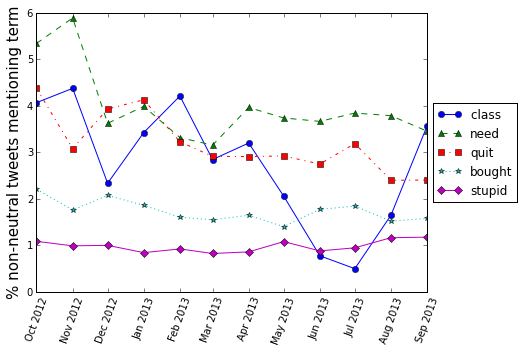

In [56]:
def get_terms_by_month(raw_tweets, term):
    matched_tweets = [t for t in search_tweets(raw_tweets, term, [], 1e10)]
    return group_by_month(matched_tweets)
    
def plot_terms_by_month(by_month, raw_tweets):
    linecycler = get_lines()
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    totals = count_tweets(by_month, keyvals=[['sent', 'positive']]) + count_tweets(by_month, keyvals=[['sent', 'negative']]) 
    for term in ['class ', 'need', 'quit', 'bought', 'stupid']:
        vals = count_tweets(get_terms_by_month(raw_tweets, term), keyvals=[['sent', 'positive']]) + count_tweets(get_terms_by_month(raw_tweets, term), keyvals=[['sent', 'negative']])
        ax.plot(months, 100. * vals / totals, next(linecycler), label=term)
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    # plt.ylim((0, 200000))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('% non-neutral tweets mentioning term', size=15)
    plt.savefig('term_trends.pdf', bbox_inches='tight')
    plt.show()
    
plot_terms_by_month(by_month, raw_tweets)

In [59]:
# Why spike in "quit" in January?
#print join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive'], ['pred_age', '<18'], ['month', sorted(by_month)[9]]]),
#                filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive'], ['pred_age', '<18']]), features))

print '\n'.join(t['text'] for t in search_tweets(raw_tweets, 'quit', [['month', sorted(by_month)[3]]]))

@saramcmillen Personal anecdote: I've 2 friends who used #ecigarette to quit real cigs. Still addicted to nicotine, but no harsh chemicals.
Stephen Dorff makes those electronic cigarettes look so cool, I'm gonna start smoking real cigarettes just so I can use them to help me quit
Just got an E-Cigarette bout to quit with my dad :)
@JordanETID some dogs just aren't ready to quit. I can't get my dog to put the electric cigarette down http://t.co/2GksPoc0
Im thinkin of favoriting this for when u slip up RT @BroadwayBrooks Im thinking of buying an electronic cigarette to help me quit officially
Abusing this electric cigarette, so hard to quit smoking
Just got an ecig to help me quit smoking ?? http://t.co/FsUdB2ui
First step to quitting #ecig #doneforgood #resolution #whoscomingwithmeman #jan http://t.co/3kJrNLI1
Freaking the fuck out where is my Ecig?! Day 1 of quitting smoking #coldturkey #godhelpme
Yes, I know I use e-cigs instead and its kinda cheating but my lungs still feel a hell of

In [61]:
# Why are youngsters talking more in April?
print '<18 compared to other ages in April'
print join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['pred_age', '<18'], ['month', sorted(by_month)[6]]]),
                filter_tweets_ind(raw_tweets, keyvals=[['month', sorted(by_month)[6]]]), features))

print '<18 in april compared to other months'
print join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['pred_age', '<18'], ['month', sorted(by_month)[6]]]),
                filter_tweets_ind(raw_tweets), features))

print 'courtney posts <18'
for age in ['<18', '18-24', '25-34', '35-44', '>=45']:
    print age, len(search_tweets(raw_tweets, 'courtney', [['pred_age', age], ['month', sorted(by_month)[6]]], 1e10))

print 'simoncowell posts <18'
for age in ['<18', '18-24', '25-34', '35-44', '>=45']:
    print age, len(search_tweets(raw_tweets, 'simoncowell', [['pred_age', age], ['month', sorted(by_month)[6]]], 1e10))
print '\n'.join(t['text'] for t in search_tweets(raw_tweets, 'courtney', [['pred_age', '<18'], ['month', sorted(by_month)[6]]], 100))

<18 compared to other ages in April
9406 target and 27924 base indices
class, ecig, e, my, an, cig, cool, in, kid, just, you, guy, their, really, smoking, e-cig, nice, kids, advice, his
<18 in april compared to other months
9406 target and 370305 base indices
courtney, f-bomb, @simoncowell, drops, ecig, \#euecigban, love, class, ad, my, twist, cig, in, an, @vapebans, njoy, honestly, \#ecig, i, metal
courtney posts <18
<18 166
18-24 17
25-34 44
35-44 41
>=45 158
simoncowell posts <18
<18 57
18-24 2
25-34 28
35-44 22
>=45 73
#CourtneyLove appears in a commercial of electronic cigarettes --&gt; http://t.co/QwuqsL8ew3
Courtney Love 'Sells Out' to E-Cigs: See her NSFW advertisement for electronic cigarettes here, but keep the v... http://t.co/rbDkIutGNT
Courtney Love Drops the F-Bomb in Ad for E-Cigarettes http://t.co/MX7pWwQpr8 {by: @mashbusiness}
Celebrity News: Courtney Love advertises electronic cigarettes http://t.co/V0UdbfKcIq
@Courtney is a bad bitch ?? RT @HuffingtonPost: Courtney L